In [1]:
import os
import shutil#
os.chdir('/content')
! git clone --branch errors https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
from glob import glob
import matplotlib.pyplot as plt
import sys
from dataset import DataSet
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 3848, done.
remote: Counting objects: 100% (884/884), done.
remote: Compressing objects: 100% (839/839), done.
remote: Total 3848 (delta 117), reused 94 (delta 45), pack-reused 2964
Receiving objects: 100% (3848/3848), 30.56 MiB | 20.61 MiB/s, done.
Resolving deltas: 100% (1062/1062), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 7.7 MB/s 
     |████████████████████████████████| 81 kB 7.8 MB/s 
     |████████████████████████████████| 149 kB 51.5 MB/s 
     |████████████████████████████████| 78 kB 6.0 MB/s 
     |████████████████████████████████| 15.7 MB 46.7 MB/s 
     |████████████████████████████████| 308 kB 59.8 MB/s 
     |████████████████████████████████| 112 kB 57.4 MB/s 
     |████████████████████████████████| 2.1 MB 55.5 MB/s 
     |████████████████████████████████| 596 kB 7.0 MB/s 
     |████████████████████████████████

4
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_M2.dat:	(148, 3)
190
0.12375296834959724
259
0.4054648962016587
260
0.2657581424344487
148
0.06527284643891335
generating 9 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 40
created union_x attribute of length 773
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (40, 235, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
['/content/hetvae/data/EDELSON/NGC4593_HX.dat', '/content/hetvae/data/EDELSON/NGC5548_W2.dat', '/content/hetvae/data/EDELSON/NGC5548_W1.dat', '/content/hetvae/data/EDELSON/NGC4593_M2.dat'] 
 (773,) (40, 235, 3) (40, 235) (40, 235)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RankWarning: Polyfit may be poorly conditioned
  import sys
/content/hetvae/src/dataset.py:328: RuntimeWarning: divide by zero encountered in true_divide
  self.dataset[:,:,2] = 1. / self.dataset[:,:,2]


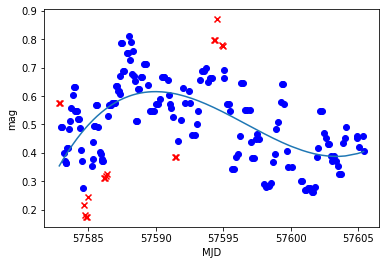

In [7]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')[:4]

# hypers: 
Edelson = DataSet() \
            .add_files(lc_files) \
            .files_to_numpy() \
            .handle_dups() \
            .prune_graham(plot=True, index=0,std_threshold=1) \
            .resample_dataset(num_samples=9) \
            .normalize() \
            .reorder() \
            .set_union_x() \
            .zero_fill() \
            .error_to_sample_weight() \
            .make_masks(frac=0.33)

print(
    Edelson.files, '\n',
    Edelson.union_x.shape,
    Edelson.dataset.shape,
    Edelson.subsampled_mask.shape,
    Edelson.recon_mask.shape
  )

# plt.scatter(Edelson.dataset[1,:-100,0], Edelson.dataset[1,:-100,1])
# Edelson.union_x.shape

In [ ]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#------------------------------

agn_df = pd.read_csv('/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv')
# handle formatting for new AGN
lcs = []
for lc_df in agn_df.groupby('Filter'):
    lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
    lcs.append(lc)
# lcs[0] = lcs[0][lcs[0][:,0].argsort()]
# lcs[0] = np.concatenate((lcs[0][:10], lcs[0][410:]))

# lcs = [lcs[0], lcs[0]]
AGN_1H2106 = DataSet()
AGN_1H2106.dataset = lcs # skip add files part

AGN_1H2106 = AGN_1H2106.handle_dups() \
                      .prune_outliers() \
                      .resample_dataset(num_samples=5) \
                      .normalize(normalize_y='individual', normalize_x='individual', x_by_range=True, y_by_range=False) \
                      .reorder() \
                      .set_union_x() \
                      .zero_fill() \
                      .error_to_sample_weight() \
                      .make_masks(frac=0.5) \
                      .set_target_x()


print(
    AGN_1H2106.union_x.shape,
    AGN_1H2106.dataset.shape,
    AGN_1H2106.subsampled_mask.shape,
    AGN_1H2106.recon_mask.shape
  )


# fig,ax = plt.subplots(5,1, figsize=(20,20))
# for i in range(5):
#     ax[i].scatter(AGN_1H2106.dataset[i,:-50,0], AGN_1H2106.dataset[i,:-50,1])

indexes of outliers to be pruned, if any: [600 601]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [418 583]
indexes of outliers to be pruned, if any: []
indexes of outliers to be pruned, if any: [ 98 205 260 261 554 555]
generating 5 new sample of each example in the dataset & appending them 
 old dataset length: 5
new dataset length: 30
created union_x attribute of length 2438
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (30, 619, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(2438,) (30, 619, 3) (30, 619) (30, 619)


/content/hetvae/src/dataset.py:319: RuntimeWarning: divide by zero encountered in true_divide
  self.dataset[:,:,2] = 1. / self.dataset[:,:,2]


In [10]:
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.3, 
                 elbo_weight=1, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.001, mixing='concat_and_mix', mse_weight=2., net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=64, rec_hidden=64, recon_loss=False, 
                 sample_tp=0.33, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=64)



In [ ]:
DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
LightCurves = np.concatenate((AGN_1H2106.dataset, AGN_1H2106.subsampled_mask[:,:,np.newaxis], AGN_1H2106.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
#LightCurves = np.concatenate((Edelson.dataset, Edelson.subsampled_mask[:,:,np.newaxis], Edelson.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
#LightCurves = np.concatenate((Catalina.dataset, Catalina.subsampled_mask[:,:,np.newaxis], Catalina.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 

print(LightCurves.shape)


(30, 619, 5)


In [ ]:
training, valid = np.split(LightCurves, [int(np.floor(0.8*len(LightCurves)))])# shuffle?

train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
       

In [ ]:
net = models.load_network(args, DIM, torch.Tensor(AGN_1H2106.union_x))
#net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x))  
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.002057519)

In [ ]:
net.query

tensor([0.0000, 0.0159, 0.0317, 0.0476, 0.0635, 0.0794, 0.0952, 0.1111, 0.1270,
        0.1429, 0.1587, 0.1746, 0.1905, 0.2063, 0.2222, 0.2381, 0.2540, 0.2698,
        0.2857, 0.3016, 0.3175, 0.3333, 0.3492, 0.3651, 0.3810, 0.3968, 0.4127,
        0.4286, 0.4444, 0.4603, 0.4762, 0.4921, 0.5079, 0.5238, 0.5397, 0.5556,
        0.5714, 0.5873, 0.6032, 0.6190, 0.6349, 0.6508, 0.6667, 0.6825, 0.6984,
        0.7143, 0.7302, 0.7460, 0.7619, 0.7778, 0.7937, 0.8095, 0.8254, 0.8413,
        0.8571, 0.8730, 0.8889, 0.9048, 0.9206, 0.9365, 0.9524, 0.9683, 0.9841,
        1.0000])

In [ ]:
def train(net, optimizer,epoch, train_loader, args, device="cuda"):
      
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          #train_batch[:,:,2] = torch.ones((train_batch[:,:,3].shape))
          train_batch = train_batch.to(device)
          x = train_batch[:,:,0]
          y = train_batch[:,:,1:2]
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:5]
          sample_weight = train_batch[:,:,2:3]
          # weights for loss in analogy to standard weighted least squares error 
  
          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              y * subsampled_mask, subsampled_mask
          ), -1) 
          recon_context_y = torch.cat((            # flux values with only recon_mask values showing
                  y * recon_mask, recon_mask
              ), -1) 
    # format: compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              x,
              context_y,  
              x,  # can pick the points we want to project to
              recon_context_y,
              num_samples=args.k_iwae, # 1? 
              beta=0.1,
              # optional, will be zero if not set
              sample_weight = sample_weight,

          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )


In [ ]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.00257519

0.002057519


In [ ]:
for epoch in range(1, 101): #args.niters + 1):
    train(net, optimizer, epoch, train_loader, args)

Iter: 100, train loss: 0.9087, avg nll: 0.2275, avg kl: 0.1548, mse: 0.665772, mae: 0.242452


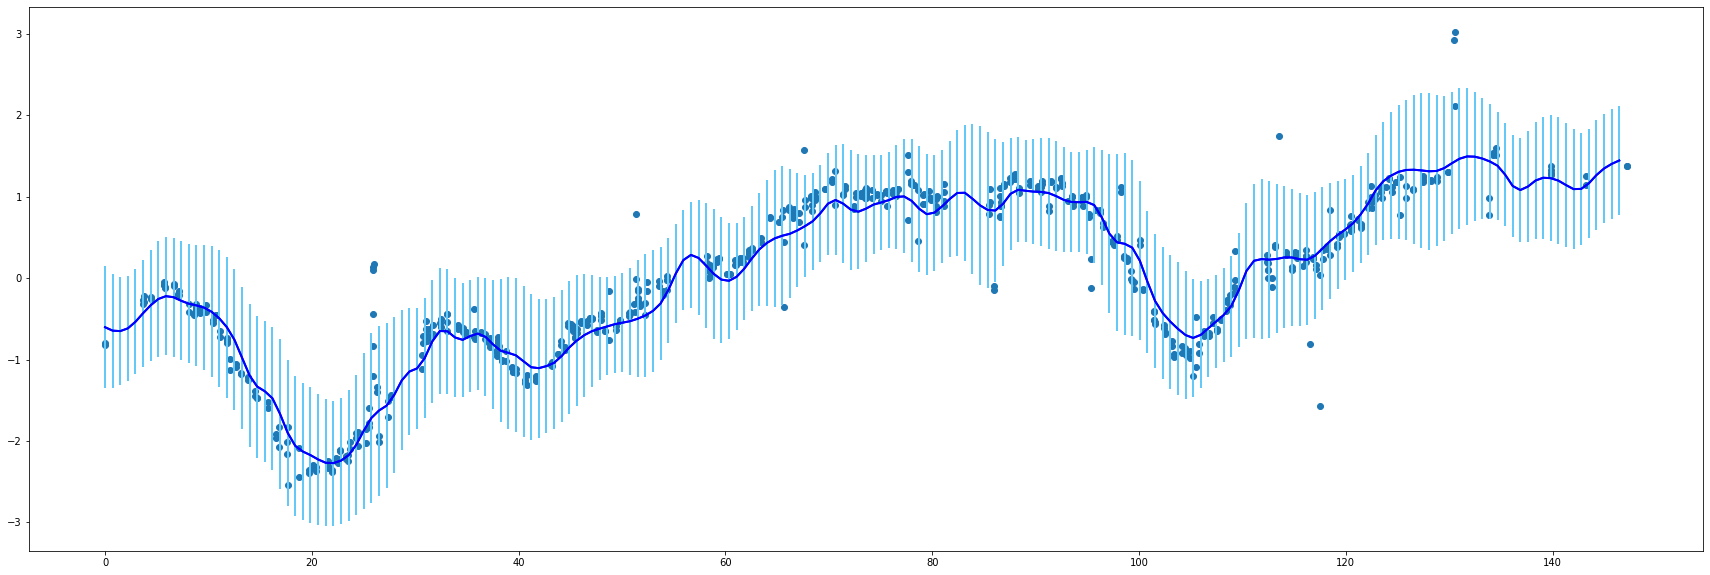

qz shape: (1, 64, 64)
reconstructed example: (200, 3)


In [ ]:
reconstruction, qz_mean, qz_std = viz_per_example(AGN_1H2106.dataset[0], AGN_1H2106.target_x[0], net, device=device, k_iwae=50)
#px, qz = viz_per_example(AGN_1H2106.dataset[6], AGN_1H2106.dataset[6,:,0], net, device=device, k_iwae=50)

In [ ]:
# visualisation for one light curve w/ increasing number of points
def viz_per_example(example, target_x, net, device="cuda", k_iwae=10, frac=0.5): 
    example = example[np.newaxis, :,:]
    target_x = target_x[np.newaxis, :, np.newaxis]
    np.random.seed(0)
    with torch.no_grad(): 
        if torch.is_tensor(example):
            example = example.cpu().numpy()
        # make new masks relative to fraction of points we got to predict w/ 
        smask, rmask = my_utils.make_masks(example, frac=frac)
        example = np.concatenate((example, smask[:,:,np.newaxis], rmask[:,:,np.newaxis], target_x), axis=-1) # format the masks 
        
        example = torch.tensor(example)
        example = example.to(device)
        
        subsampled_mask = example[:,:,3:4]
        context_y = torch.cat((example[:,:, 1:2] * subsampled_mask, subsampled_mask), -1)
        px, qz = net.get_reconstruction(example[:,:, 0], context_y, example[:,:,5], num_samples=k_iwae)

        qz_mean = (qz.mean.cpu().numpy())
        qz_std = (torch.exp(0.5 * qz.logvar).cpu().numpy())
        px_mean = px.mean.cpu().numpy()
        px_std = torch.exp(0.5 * px.logvar).cpu().numpy()
        example = example.cpu().numpy()

        px_mean = np.mean(px_mean, axis=0)[0,:200,0]
        px_std = np.mean(px_std, axis=0)[0,:200,0]
        target_x = target_x[0,:200,0]
        w=2.0
        plt.figure(figsize=(30, 10))
        #plt.fill_between(target_x, px_mean - 2*px_std, px_mean+2*px_std, color='gray')

        plt.plot(target_x, px_mean, c='b', lw=w, label='Reconstructions', zorder=20)
        plt.scatter(example[0,:,0], example[0,:,1])
        plt.errorbar(target_x, px_mean ,yerr=px_std,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions')

        plt.show()
        reconstruction = np.concatenate((target_x[:,np.newaxis], px_mean[:,np.newaxis], px_std[:,np.newaxis]), axis=1)
        print(f'qz shape: {qz_mean.shape}')
        print(f'reconstructed example: {reconstruction.shape}')
        return reconstruction, qz_mean,qz_std



In [ ]:
reconstruction.shape

(200, 3)

<ErrorbarContainer object of 3 artists>

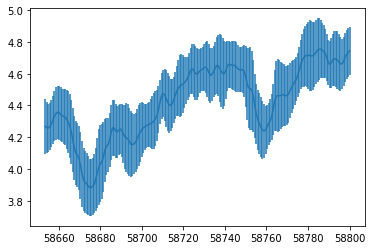

In [ ]:
x_mean, x_std = AGN_1H2106.x_mean_std[0]
y_mean, y_std = AGN_1H2106.y_mean_std[0]


x = (reconstruction[:,0] * x_std) + x_mean
y = (reconstruction[:,1] * y_std) + y_mean
yerr = reconstruction[:,2] * y_std
plt.errorbar(x,y,yerr=yerr)





/content/hetvae/src/dataset.py:208: RuntimeWarning: divide by zero encountered in true_divide
  self.dataset[:,:,2] = 1. / self.dataset[:,:,2]


<ErrorbarContainer object of 3 artists>

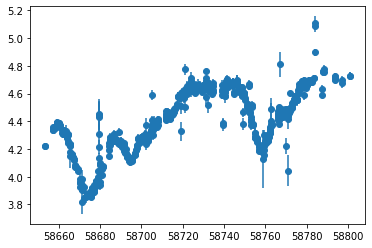

In [ ]:
denorm_AGN = AGN_1H2106.error_to_sample_weight().denormalize()
x = denorm_AGN[0,:,0]
y = denorm_AGN[0,:,1]

yerr = denorm_AGN[0,:,2]



plt.errorbar(x,y,yerr=yerr, fmt='o')

